# Root Trees

Goal: Load files, load trees, plot with cuts, save results

## Load Data from ROOT-Files

In [2]:
# Load ROOT module
import ROOT
import rootnotes                         # only used to show root plots in notebooks
import rootprint

ModuleNotFoundError: No module named 'ROOT'

In [2]:
# Load data from file
# TFile(const char* fname, Option_t* option = "", const char* ftitle = "", Int_t compress = 1)
file = ROOT.TFile("scan.root","READ")

The easiest way to get a first glimps of any root files is the [TBrowser](http://root.cern.ch/root/html/TBrowser.html). It allows to browse all root files.

The "scan.root" file contains a tree called "Coin" with 4 different branches (energy1, energy2, deltaTcc, deltaTfine) as well as a histogram "statFrames". PLAY WITH TBROWSER.

In [3]:
# ROOT.TBrowser()

In [4]:
# load tree and show branches
tree = file.Get("Coin")
print "Total entries: ", tree.GetEntries()
print "Branches:"
for i in range(4):
    print "  -",tree.GetListOfBranches()[i].GetName()

Total entries:  20368
Branches:
  - energy1
  - energy2
  - deltaTcc
  - deltaTfine


## Plot Data from Trees

In [5]:
# plot energies
# from http://root.cern.ch/root/html/TTree.html#TTree:Draw@1
# Draw(const char* varexp, const TCut& selection, Option_t* option = "", Long64_t nentries = 1000000000, Long64_t firstentry = 0)

#c1 = ROOT.TCanvas("c1")
c1 = rootnotes.default_canvas()
c1.Divide(2,2)
c1.cd(1)
tree.Draw("energy1")
c1.cd(2)
tree.Draw("energy2>>he2(601,0,600)")                        # hisogram "he2" with 601 bins from 0 to 600 is saved in global gDirectory

By default histograms created by tree.Draw() are called htemp. By adding ">>hname" is the varexp expression the histogram is called hname and stored in gDirectory (class [TDirectory](http://root.cern.ch/root/html/TDirectory.html)). 

In [6]:
# load hisograms from gDirectory
he2 = ROOT.gDirectory.Get("he2")                            # load hisogram from gDirectory
he1 = ROOT.gROOT.FindObject("htemp").Clone()                # or find the object "htemp"
he1.SetName("he1")
c1

### Scatter Plots

In [7]:
# Draw correlations between the two energy channels
c1.cd(3)                                                          # select third Pad
tree.Draw("energy1:energy2>>he(601,0,600,601,0,600)","","zcol")   # plot scatter plot with color 
he = ROOT.gDirectory.Get("he")
he.GetXaxis().SetTitle("energy1")
he.GetYaxis().SetTitle("energy2")
c1

In [8]:
# Create an Alias
# from http://root.cern.ch/root/html/TTree.html
# SetAlias(const char* aliasName, const char* aliasFormula)
tree.SetAlias("deltaT","deltaTfine*51")                           # deltaTfine is given in 51ps bins
c1.cd(4)                                                          # select 4th Pad
tree.Draw("deltaT>>ht(117,-3000,3000)")
ht = ROOT.gDirectory.Get("ht")
ht.GetXaxis().SetTitle("deltaT [ps]")

### Repetition: Fit Gaus

In [9]:
%%rootprint
# define the functions
ge1 = ROOT.TF1("ge1","gaus",420,520)
ge2 = ROOT.TF1("ge2","gaus",380,500)

# performe the two fits
c1.cd(1)                                   # select pad
ROOT.gStyle.SetOptFit(1111)                # enable fit sttistics
he1.Fit("ge1","R")                         # fit within given range
c1.cd(2)
ROOT.gStyle.SetOptFit(1111)
he2.Fit("ge2","R")

## Cuts

In [10]:
# Plot deltaT of Photopeak events
c1.cd(4)
energy1_lower = ge1.GetParameter("Mean")-1.5*ge1.GetParameter("Sigma")
energy1_upper = ge1.GetParameter("Mean")+1.5*ge1.GetParameter("Sigma")
energy2_lower = ge2.GetParameter("Mean")-1.5*ge2.GetParameter("Sigma")
energy2_upper = ge2.GetParameter("Mean")+1.5*ge2.GetParameter("Sigma")
tree.Draw("deltaT>>ht2(117,-3000,3000)","energy1>"+str(energy1_lower)+"&&energy1<"+str(energy1_upper)+"&&energy2>"+str(energy2_lower)+"&&energy2<"+str(energy2_upper),"SAME")
ROOT.gPad.SetLogy()

In [12]:
# Indicate the cuts in the scatter plot
# from http://root.cern.ch/root/html/TLine.html
# TLine(Double_t x1, Double_t y1, Double_t x2, Double_t y2)
c1.cd(3)
l11 = ROOT.TLine(0,energy1_lower,600,energy1_lower)
l12 = ROOT.TLine(0,energy1_upper,500,energy1_upper)
l21 = ROOT.TLine(energy2_lower,0,energy2_lower,600)
l22 = ROOT.TLine(energy2_upper,0,energy2_upper,600)
l11.Draw()
l12.Draw()
l21.Draw()
l22.Draw()
c1

## Alternative Way to Fill Histograms

TFile::Append:0: RuntimeWarning: Replacing existing TH1: tnew (Potential memory leak).


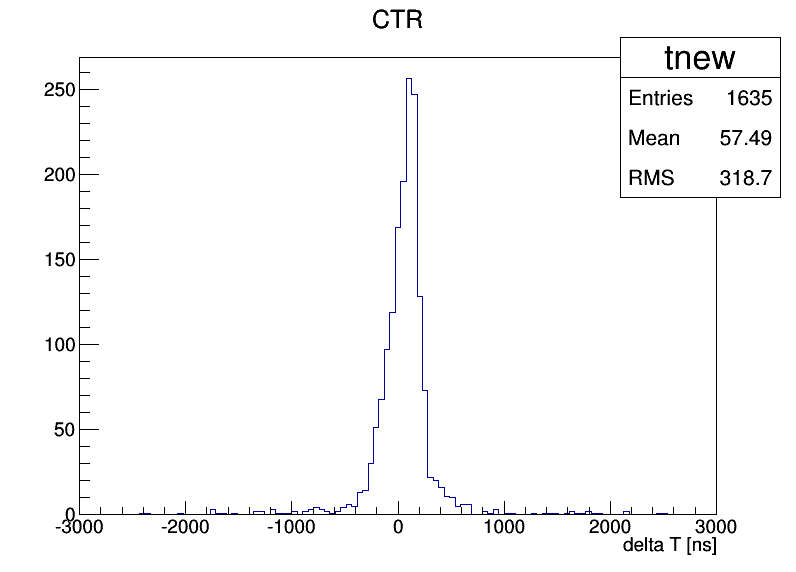

In [47]:
# filling histograms by looping through all events
c2 = ROOT.TCanvas("c2")
c2 = rootnotes.default_canvas()

tnew = ROOT.TH1F("tnew","CTR",117,-3000,3000)                  # Create hisogram which will be filled
for event in tree:
    if (event.energy1 > energy1_lower) & (event.energy1 < energy1_upper) & (event.energy2 > energy2_lower) & (event.energy2 < energy2_upper):
        tnew.Fill(event.deltaTfine*51)
tnew.GetXaxis().SetTitle("delta T [ns]")
tnew.Draw()
c2